In [31]:
import os
import sys
sys.path.append('../va_pipeline/')
import json
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import string

from calculate_accuracy import *
# from drawbox import *
from process import *
from sensor import exec_file



In [32]:
test_dir = '../samples/testing/videos/'

# for vid in list(os.listdir(test_dir)):
#     print(os.path.join(test_dir, vid))
    # cap = cv2.VideoCapture(os.path.join(test_dir, vid))
queue = [cap.read()[1], cap.read()[1], cap.read()[1]]

ret, prev = cap.read()
frame_no = 1
frames_processed = 1

diffs = []
while frame_no <= 250:
    ret, frame = cap.read()

    if not ret:
        break
    
    queue.pop(0)
    queue.append(frame)
    frame = get_diff(queue[0], queue[1], queue[2])
    
    frame_no += 1

# df[vid] = diffs
cap.release()
df.plot()


NameError: name 'cap' is not defined

In [33]:
file = './test_results/config_testing/resolution/'
stats = 'stats/'
column_order = ['Video', 'Width (px)', 'Height (px)', 'Frame Rate (fps)']
dfs = []

def get_average_size(df_path, x_res, y_res):
    average_size = 0
    df = pd.read_csv(df_path, index_col=0)
    
    for row in df.iterrows():
        average_size += (row[1][2] * row[1][3])
    
    average_size /= len(df)
    
    return average_size


for video in list(os.listdir(os.path.join(file, 'stats/'))):
    file_name = '_'.join(os.path.splitext(video)[0].split('_')[0:-1]) # Get file name
    stats = os.path.join(file, 'stats/', file_name + '_stats.txt')
    inference = os.path.join(file, 'inference/', file_name + '_inference.csv')
    energy = os.path.join(file, 'energy/', file_name + '_energy.csv')
    
    df = pd.read_csv(stats, \
            sep=': ', header=None, engine='python').set_index(0)
    df = df.transpose().reset_index(drop=True)

    config_params = os.path.basename(stats).split('_')

    # Setting columns based on params
    df['Video'] = config_params[0] + config_params[1] + config_params[2]
    df['Width (px)'], df['Height (px)'], df['Frame Rate (fps)'] = \
    config_params[1], config_params[2], config_params[3]
    df = df.astype({'Width (px)': int, 'Height (px)': int})

    # Add columns
    df['Resolution (px)'] = df['Width (px)'].multiply(df['Height (px)'])
    df['Resolution (1000s of px)'] = df['Resolution (px)'] / 1000
    df['Energy (1000s of J)'] = df['energy'] / 1000
    df['Energy (J) per frame'] = df['energy'] / 250


    # Count # of detections
    with open(inference, 'r') as f:
        lines = f.readlines()
        df['Detections'] = len(lines) - 1  # subtract the first line, which is cols of df
    
    # Average object size
    df['Average detection size'] = get_average_size(inference, df['Width (px)'], df['Height (px)'])
                
    df = df.reindex(columns=column_order+[x for x in df.columns if x not in column_order])
    dfs.append(df)

out = pd.concat(dfs)

In [34]:
out

,Video,Width (px),Height (px),Frame Rate (fps),frames,runtime (inference),average time per frame,runtime (total),energy,avg power,energy per frame,mAP,Resolution (px),Resolution (1000s of px),Energy (1000s of J),Energy (J) per frame,Detections,Average detection size
0,largefast1280720,1280,720,25,250.0,518.927982,2.075712,537.317521,2757.386016,5.131763,11.029544,1.000000,921600,921.6,2.757386,11.029544,147,49908.430436
0,largefast640360,640,360,25,250.0,156.686196,0.626745,174.813801,862.947581,4.936381,3.451790,0.848828,230400,230.4,0.862948,3.451790,160,49850.756243
0,largefast960540,960,540,25,250.0,308.198814,1.232795,326.328749,1622.710047,4.972624,6.490840,0.808353,518400,518.4,1.622710,6.490840,165,49001.834051
0,largeslow1280720,1280,720,25,250.0,502.505254,2.010021,520.979493,2827.249242,5.426796,11.308997,1.000000,921600,921.6,2.827249,11.308997,211,15497.963120
0,largeslow640360,640,360,25,250.0,154.691124,0.618764,172.954266,849.801572,4.913447,3.399206,0.095077,230400,230.4,0.849802,3.399206,648,53517.621455
0,largeslow960540,960,540,25,250.0,305.614269,1.222457,323.913642,1615.294090,4.986805,6.461176,0.123466,518400,518.4,1.615294,6.461176,629,50895.763589
0,smallfast1280720,1280,720,25,250.0,522.816305,2.091265,541.251187,2714.707892,5.015616,10.858832,1.000000,921600,921.6,2.714708,10.858832,1008,4532.297052
0,smallfast640360,640,360,25,250.0,154.725794,0.618903,172.825385,854.196528,4.942541,3.416786,0.115544,230400,230.4,0.854197,3.416786,520,7606.854128
0,smallfast960540,960,540,25,250.0,307.648461,1.230594,325.696415,1619.302263,4.971815,6.477209,0.204382,518400,518.4,1.619302,6.477209,807,5657.299138
0,smallslow1280720,1280,720,25,250.0,517.256417,2.069026,535.767014,2692.536870,5.025574,10.770147,1.000000,921600,921.6,2.692537,10.770147,596,2196.183202


<Axes: xlabel='Video'>

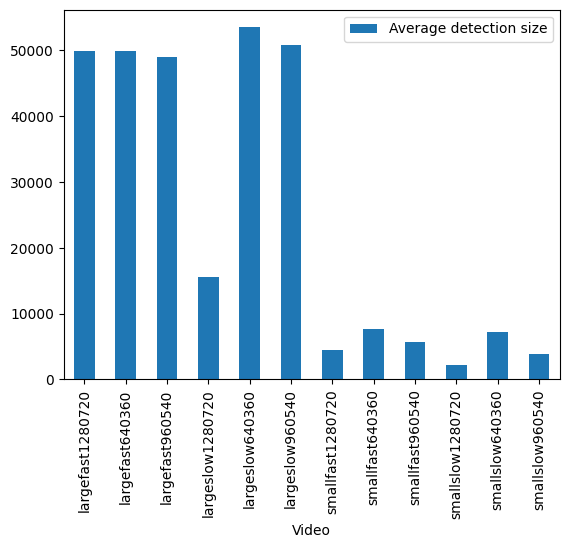

In [41]:
out.plot.bar('Video', 'Average detection size')

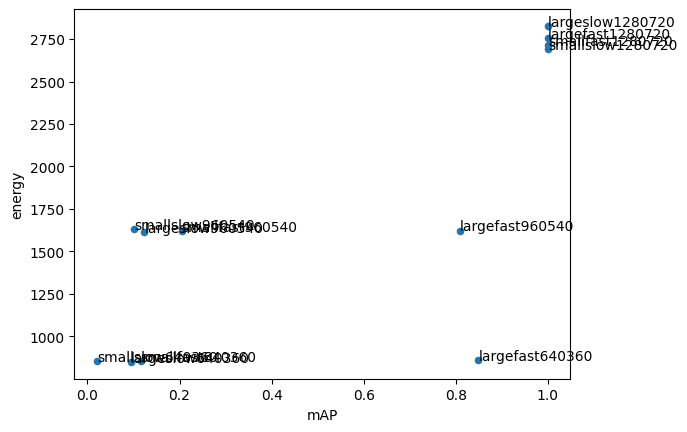

In [40]:
#create scatter plot of assists vs. points
ax = out.plot(kind='scatter', x='mAP', y='energy')

#label each point in scatter plot
for idx, row in out.iterrows():
    ax.annotate(row['Video'], (row['mAP'], row['energy']))